# Exploring Venues in Vadodara, Gujarat, India using Foursquare API and Zomato API

## Introduction

The aim of the project is to identify venues in Vadodara, Gujarat, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Vadodara, Gujarat, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## APIs used for this project
* **Foursquare API:** We will use the Foursquare API to fetch venues in Vadodara starting from the middle upto 4 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [2]:
VAD_LATITUDE = '22.3072'
VAD_LONGITUDE = '73.1812'
print('The geograpical coordinates of Vadodara are {}, {}.'.format(VAD_LATITUDE, VAD_LONGITUDE))

The geograpical coordinates of Vadodara are 22.3072, 73.1812.


Using folium to create zoomed map of Vadodara

In [4]:
!pip install folium
import folium

vadodara_map = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)
folium.Marker([VAD_LATITUDE, VAD_LONGITUDE]).add_to(vadodara_map)
#vadodara_map.save("maps/Chandigarh Map.html")
vadodara_map

     |████████████████████████████████| 93 kB 4.1 MB/s  eta 0:00:01


### Foursquare API

We begin by fetching a total of all venues in **Vadodara** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [6]:
FOURSQUARE_CLIENT_ID = 'ISVVX3QLJV4QKSAAZGCIAPKV3I3PPREVGTQLLQ3LCM0T4DIQ'
FOURSQUARE_CLIENT_SECRET = 'L2SJ1TNXISRCQKIBK5OOEMFZXOCCZVTAWJXSWN1UGW0321AC'
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20201126'

We define the `get_category_type` method to get the correct category for each venue.

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Fetching 100 venues within 4km radius using Foursquare API

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        VAD_LATITUDE, 
                                                                        VAD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:33: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 1 venues fetched within a total radius of 4.0 Km

Total 101 venues fetched


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [11]:
headers = {'user-key': '<USER-KEY>'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

Plotting Foursquare data on map

In [12]:
vadodara_map_fs = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(vadodara_map_fs)  

#vadodara_map_fs.save("maps/Venues by Foursquare.html")
vadodara_map_fs

Plotting Zomato Data on map

In [13]:
vadodara_map_zm = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(vadodara_map_zm)  

#vadodara_map_zm.save("maps/Venues by Zomato.html")
vadodara_map_zm

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [14]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [15]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [16]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Crossword,Bookstore,22.3137,73.1750,Cafe Coffee Day,22.3139,73.1752,700.0,2.0,2.7,"Crossword Book Store, Shoppers Stop, Arunoday ...",0.0002,0.0002
1,Vishal Sandwich,Sandwich Place,22.3111,73.1685,Vishal Sandwich,22.3108,73.1684,150.0,1.0,4.4,"G 09, Kanha Capital, Vadiwadi, Vadodara",-0.0003,-0.0001
2,Khamma Ghani,Indian Restaurant,22.3084,73.1682,Ghani Khamma,22.3081,73.1686,900.0,3.0,4.0,"FF- 4/5/6, CAPRY HOUSE-2, SUDHANAGAR JETALPUR ...",-0.0003,0.0004
3,That Place,Italian Restaurant,22.3083,73.1761,That Place,22.3083,73.1761,1500.0,4.0,4.2,"33, Sampatrao Colony, Alkapuri, Vadodara",0.0000,0.0000
4,Fiorella Ristorante & Pizzeria,Italian Restaurant,22.3123,73.1718,Fiorella - Hotel Express Residency,22.3123,73.1721,1500.0,4.0,4.3,"18/19, Hotel Express Residency, Alkapuri, Vado...",0.0000,0.0003
5,KFC,Fast Food Restaurant,22.3173,73.1695,KFC,22.3174,73.1693,450.0,2.0,4.3,"19, Ground Floor, Vadodara Central Mall, Near ...",0.0001,-0.0002
6,Maruti Nandan Soda Centre,Snack Place,22.3044,73.1643,Jay Maruti Nandan Soda,22.3045,73.1642,100.0,1.0,4.1,"Shop 2, Shivalay Complex, Hari Bhakti, Jagdish...",0.0001,-0.0001
7,Havmor Restaurant,Indian Restaurant,22.3018,73.1657,Havmor - The Eatery,22.3018,73.1658,600.0,2.0,4.1,"56, Punit Nagar Society, Old Padra Road, Diwal...",0.0000,0.0001
8,Swagat Restaurant,Indian Restaurant,22.3078,73.1708,Twisted Potato,22.3078,73.1710,200.0,1.0,3.3,"E/5, Ground Floor, Tower 2, Kashivishweshvar C...",0.0000,0.0002
9,Pizza on the Rock,Pizza Place,22.2983,73.1648,Pizza On The Rock,22.2983,73.1648,500.0,2.0,4.3,"Maryland Complex, Opposite Gauri Sarees, Old P...",0.0000,0.0000


Dropping mismatched categories

In [17]:
selected_venues = selected_venues.drop([0, 12, 13, 27, 32, 37, 39, 40, 41, 43, 44, 45, 54, 56, 60]).reset_index(drop = True)

In [18]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Final Dataset

In [19]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Sandwich Place,Vishal Sandwich,22.3108,73.1684,1.0,4.4,"G 09, Kanha Capital, Vadiwadi, Vadodara",75.0
1,Indian Restaurant,Ghani Khamma,22.3081,73.1686,3.0,4.0,"FF- 4/5/6, CAPRY HOUSE-2, SUDHANAGAR JETALPUR ...",450.0
2,Italian Restaurant,That Place,22.3083,73.1761,4.0,4.2,"33, Sampatrao Colony, Alkapuri, Vadodara",750.0
3,Italian Restaurant,Fiorella - Hotel Express Residency,22.3123,73.1721,4.0,4.3,"18/19, Hotel Express Residency, Alkapuri, Vado...",750.0
4,Fast Food Restaurant,KFC,22.3174,73.1693,2.0,4.3,"19, Ground Floor, Vadodara Central Mall, Near ...",225.0


In [20]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 45


## Analysis 

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 17 artists>

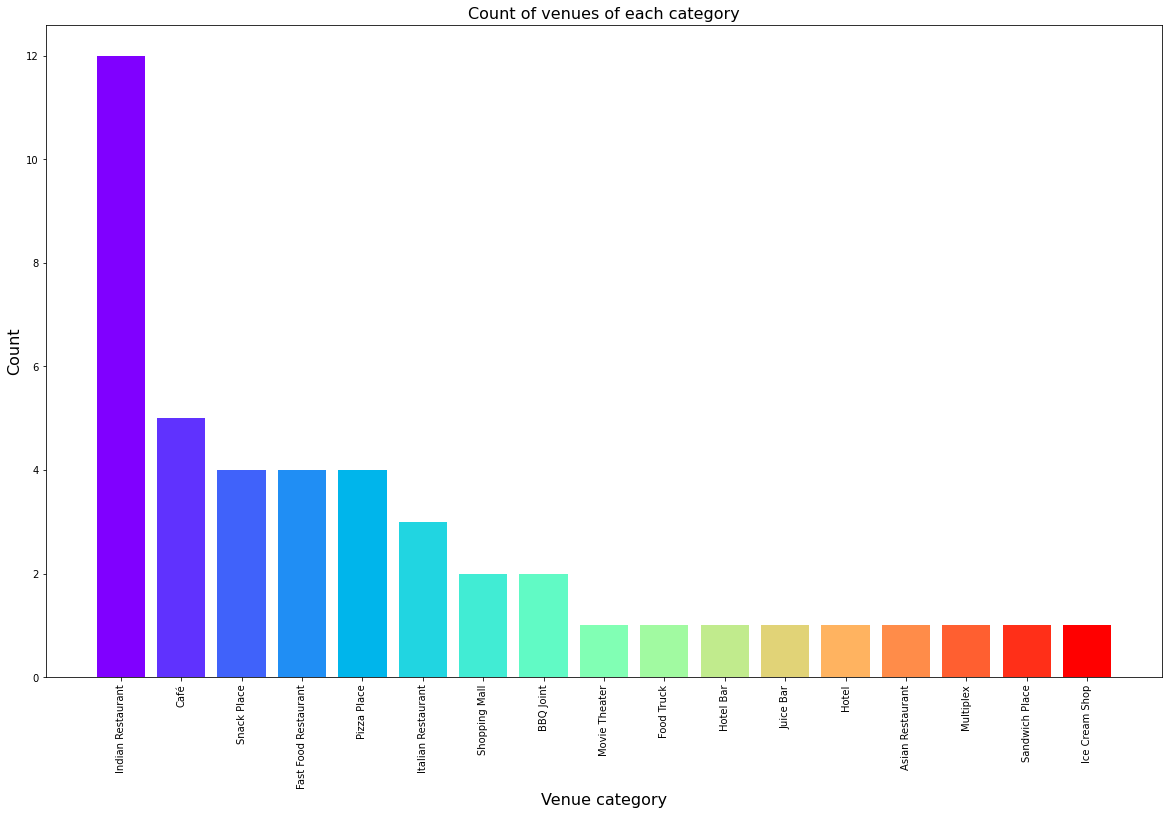

In [21]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Cafe** and **Indian Restaurant**. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

Text(0.5, 1.0, 'Count of venues with given rating')

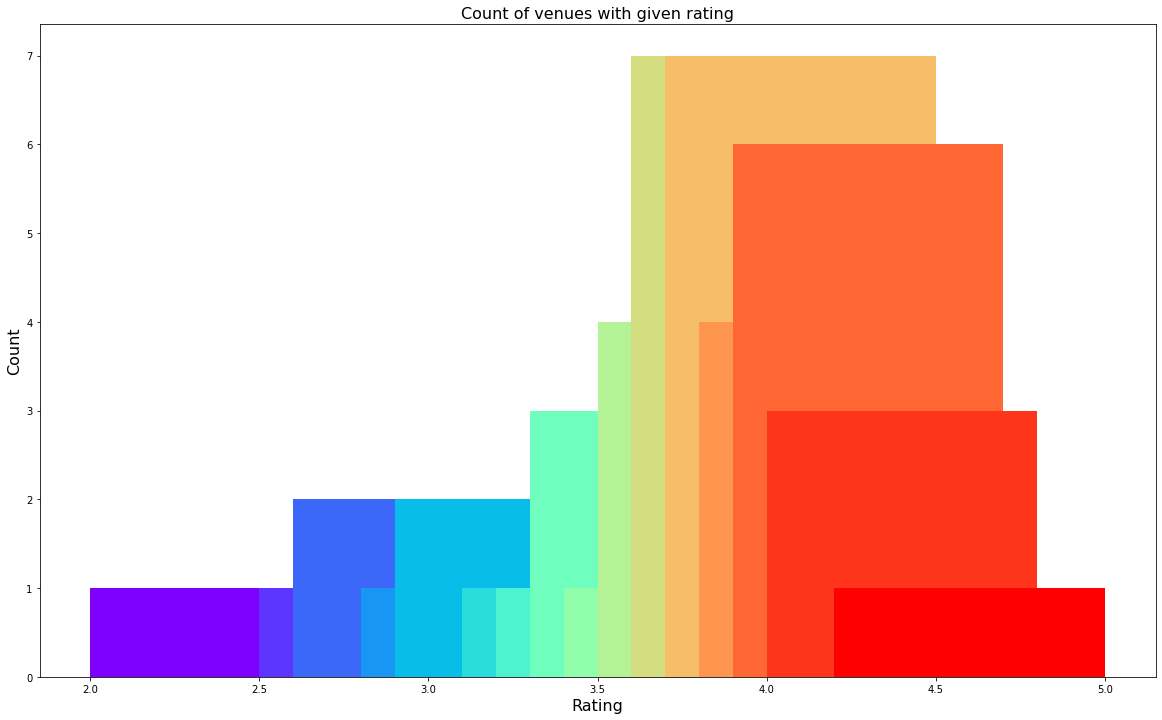

In [22]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

In [23]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Plotting venues on map

In [25]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

vadodara_map_vn = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(vadodara_map_vn)  

#vadodara_map_vn.save("maps/Venues Ratings.html")
vadodara_map_vn

The map shows that majority of venues with ratings 3+ are in the are of Manjalpur, Tandalja and Alkapuri.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

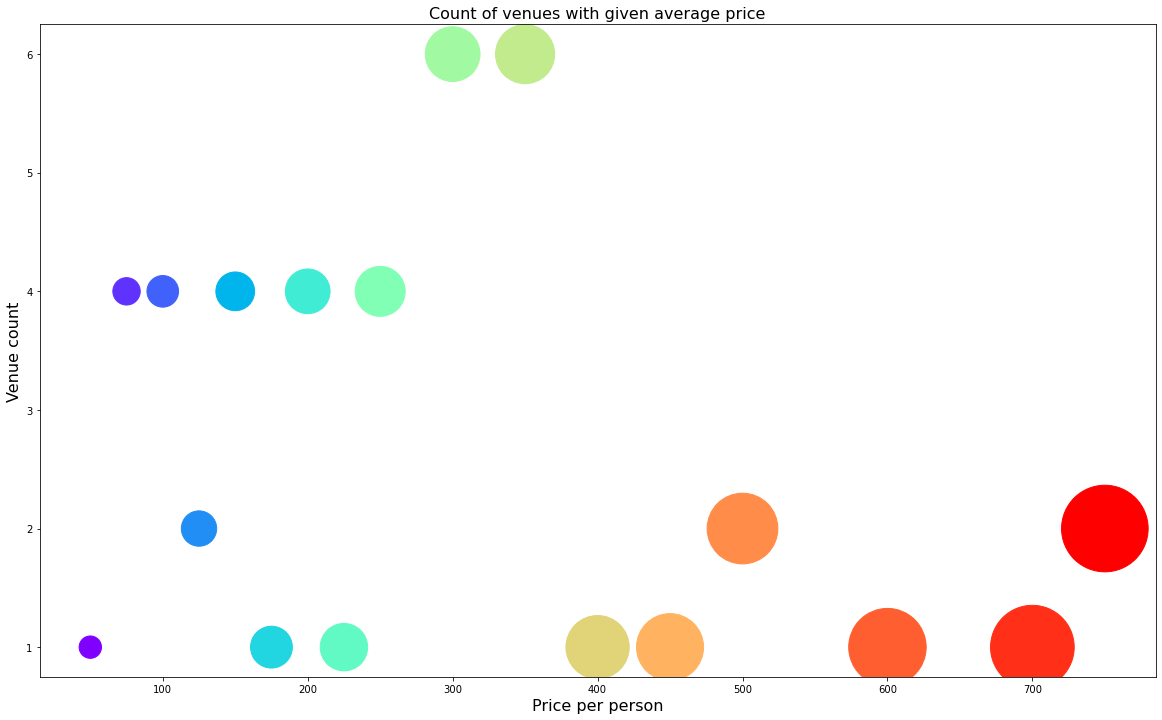

In [26]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot we can say that many venues fall between 200-300 price range.

In [28]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

vadodara_map_pr = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(vadodara_map_pr)  

#vadodara_map_pr.save("maps/Venues Prices.html")
vadodara_map_pr

The map plotted says that most venues have an average price. Though Alkapuri area have high price venues.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into three separate groups.

In [29]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Sandwich Place,Vishal Sandwich,22.3108,73.1684,1.0,4.4,"G 09, Kanha Capital, Vadiwadi, Vadodara",75.0,Very good
1,2,Indian Restaurant,Ghani Khamma,22.3081,73.1686,3.0,4.0,"FF- 4/5/6, CAPRY HOUSE-2, SUDHANAGAR JETALPUR ...",450.0,Good
2,1,Italian Restaurant,That Place,22.3083,73.1761,4.0,4.2,"33, Sampatrao Colony, Alkapuri, Vadodara",750.0,Very good
3,1,Italian Restaurant,Fiorella - Hotel Express Residency,22.3123,73.1721,4.0,4.3,"18/19, Hotel Express Residency, Alkapuri, Vado...",750.0,Very good
4,2,Fast Food Restaurant,KFC,22.3174,73.1693,2.0,4.3,"19, Ground Floor, Vadodara Central Mall, Near ...",225.0,Very good


In [30]:
vadodara_map_cluster = folium.Map(location = [VAD_LATITUDE, VAD_LONGITUDE], zoom_start = 13)
color_map = { 0: 'yellow', 1: 'orange', 2:'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(vadodara_map_cluster)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(vadodara_map_cluster)

#vadodara_map_cluster.save("maps/Venues Clusters.html")
vadodara_map_cluster

The first and third clusters are spread across the city while second cluster is very sparsely spread and also have less venues

Let's check the venues of the clusters

In [31]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Sandwich Place,Vishal Sandwich,22.3108,73.1684,1.0,4.4,"G 09, Kanha Capital, Vadiwadi, Vadodara",75.0,Very good
1,0,Snack Place,Jay Maruti Nandan Soda,22.3045,73.1642,1.0,4.1,"Shop 2, Shivalay Complex, Hari Bhakti, Jagdish...",50.0,Very good
2,0,Indian Restaurant,Twisted Potato,22.3078,73.1710,1.0,3.3,"E/5, Ground Floor, Tower 2, Kashivishweshvar C...",100.0,Good
3,0,Food Truck,Raju Omlet,22.3225,73.1972,1.0,4.2,"Mahalaxmi Apartment, Opposite B O B, Karoli Ba...",150.0,Very good
4,0,Indian Restaurant,22nd Parallel,22.3083,73.1680,2.0,4.6,"1st Floor, Tapan Complex, Besides M Cube Mall,...",200.0,Very good
5,0,Snack Place,Bombay Sandwich Bites,22.3107,73.1724,1.0,4.0,"SB-2, Centre Point, R.C. Dutt, Alkapuri, Vadodara",100.0,Good
6,0,Indian Restaurant,Jay Mahakali Sev Usal,22.2960,73.1984,1.0,4.4,"14 & 15, Prathmesh Plazza, Behind Nehru Bhavan...",75.0,Very good
7,0,Shopping Mall,Kesar Cafe,22.3221,73.1657,1.0,3.6,"BKS8, 2nd Floor, Food Court, Inorbit Mall, Sub...",125.0,Good
8,0,Fast Food Restaurant,Subway,22.3225,73.1974,1.0,4.1,"Ground Floor, Goverdhan Apartment, Near Utkars...",100.0,Very good
9,0,Café,WAFL Cafe,22.3189,73.1878,1.0,3.3,"GF 9, Saffron Complex, Opposite Fatehgunj Chur...",125.0,Good


In [33]:
print("The venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

The venues for cluster 0 have mean price range of 1.25 and rating spread around 4.01


In [34]:
result_2 = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result_2.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Italian Restaurant,That Place,22.3083,73.1761,4.0,4.2,"33, Sampatrao Colony, Alkapuri, Vadodara",750.0,Very good
1,1,Italian Restaurant,Fiorella - Hotel Express Residency,22.3123,73.1721,4.0,4.3,"18/19, Hotel Express Residency, Alkapuri, Vado...",750.0,Very good
2,1,Indian Restaurant,Kalaghoda- Effotel By Sayaji,22.3083,73.1875,3.0,3.9,"Effotel By Sayaji, Kalaghoda Circle, Sayajigun...",500.0,Good
3,1,Italian Restaurant,San Sizzler's,22.3095,73.1752,3.0,3.7,"83, Samaptrao Colony, Mangaldhara Complex, Alk...",500.0,Good
4,1,Asian Restaurant,Kai Asia - Vivanta Vadodara,22.2935,73.1746,3.0,4.0,"Vivanta Hotel, Akota Gardens, Near Gold Gym, A...",700.0,Good
5,1,Hotel Bar,Pinxx - Royal Orchid Central,22.2869,73.1690,3.0,3.5,"Royal Orchid Central, Mujmahuda, Akota, Vadodara",600.0,Good


In [37]:
print("The venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result_2['price_range'].mean(), result_2['rating'].astype(float).mean()))

The venues for cluster 1 have mean price range of 3.33 and rating spread around 3.93


In [36]:
result_3 = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result_3.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Indian Restaurant,Ghani Khamma,22.3081,73.1686,3.0,4.0,"FF- 4/5/6, CAPRY HOUSE-2, SUDHANAGAR JETALPUR ...",450.0,Good
1,2,Fast Food Restaurant,KFC,22.3174,73.1693,2.0,4.3,"19, Ground Floor, Vadodara Central Mall, Near ...",225.0,Very good
2,2,Indian Restaurant,Havmor - The Eatery,22.3018,73.1658,2.0,4.1,"56, Punit Nagar Society, Old Padra Road, Diwal...",300.0,Very good
3,2,Pizza Place,Pizza On The Rock,22.2983,73.1648,2.0,4.3,"Maryland Complex, Opposite Gauri Sarees, Old P...",250.0,Very good
4,2,Shopping Mall,The Barbeque Grill,22.3182,73.1697,2.0,3.9,"3rd Floor, Centre Square Mall, Near Genda Circ...",350.0,Good
5,2,Movie Theater,Neopolitan Pizza,22.3228,73.1869,2.0,3.2,"3rd Floor, Seven Seas Mall, Fatehgunj, Vadodara",300.0,Good
6,2,Fast Food Restaurant,Goodies,22.3104,73.1587,2.0,3.8,"Near Natu Bhai Circle, Ellorapark, Vadiwadi, V...",350.0,Good
7,2,Café,Cafe Coffee Day,22.3238,73.1899,2.0,2.4,"Silver Bell Complex, Fatehgunj Main Road, Oppo...",350.0,Okay
8,2,BBQ Joint,Ustaad Miyaan,22.3096,73.1714,2.0,4.3,"13 Alkapuri shopping center, opposite vishwas ...",300.0,Very good
9,2,BBQ Joint,The Barbeque Grill,22.3182,73.1697,2.0,3.9,"3rd Floor, Centre Square Mall, Near Genda Circ...",350.0,Good


In [38]:
print("The venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result_3['price_range'].mean(), result_3['rating'].astype(float).mean()))

The venues for cluster 2 have mean price range of 2.11 and rating spread around 3.79


#### Results and Discussion

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Vadodara, Gujarat, India.

After collecting data from the **Foursquare** and **Zomato** APIs, we got a list of 101 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 49.

We identified that from the total set of venues, majority of them were **Cafes** and **Indian Restaurants**. A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Vadodara.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Manjalpur, Alkapuri and Tandalja**. These clusters also have very **high ratings (more than 3)**.

When we take a look at the price values of each venue, we explore that **many venues** have prices which are in the **range of Rs 200 to Rs 300 for one person**. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 700.

Finally, through clusters we identified that there are **many venues** which are **relatively lower priced but have an average rating of 4.01**. On the other hand, there are **few venues** which are **high priced and have average rating of 3.79**.

1. If you're looking for cheap places with relatively high rating, you should check **Manjalpur**.
2. If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit **Alkapuri**.
3. If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try between **Manjalpur** and **Alkapuri**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion

The purpose of this project was to explore the places that a person visiting Vadodara could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Alkapuri, Manjalpur and Tandalja. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.